# MATERNAL HEALTH RISK PREDICTION

Assessing Pregnancy Risks: EDA, Modeling, and Hypothesis Testing

 <p>Este cuaderno está inspirado en el Trabajo de :<a href="https://www.kaggle.com/code/annastasy/pregnancy-risks-eda-modeling-hypothesis#Assessing-Pregnancy-Risks:-EDA,-Modeling,-and-Hypothesis-Testing" title="Pregnancy Risk">
este notebook de pregnancy risk prediction</a>.</p>

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

## Vamos a entender nuestros datos y entender el papel de las etiquetas risk

In [18]:
df= pd.read_csv("Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Miramos duplicados:

In [23]:
df[df.duplicated(keep='first')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


Observamos si hay mujeres menores a 13 años y mayores de 60, ya que no son fertiles. 

In [26]:
print(f"número de mujeres mayores de 60 años: {len(df[df.Age > 60])} y el número de mujeres menores de 13 es {len(df[df.Age < 13])}")


número de mujeres mayores de 60 años: 8 y el número de mujeres menores de 13 es 39


Exploramos la cantidad de mujeres con baja frecuencia cardíaca: 

In [29]:
df[df.HeartRate < 60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


**Principales Hipótesis**

<ul>
    <li>Tenemos 1014 entradas y 7 variables.</li>
    <li>las primeras 5 columnas como ya vimos en el notebook <code>wearable_sintetico</code> sonn tipo int menos dos float.</li>
    <li>La columna de RiskLevel es un objeto y para el algoritmo de ML hay que pasarlo a tipo numérico.</li>
    <li>No hay valores nulos.</li>
    <li>Hay muchas filas duplicadas.</li>
    <li>El rango de edad es desde los 10 a los 70 años. Aunque no sea legal en Europa, hay niñas con capacidad de quedarse
    embarazadas a los 10 años en otros países.</li>
</ul>

## Limpieza de los datos

In [34]:
data = df.copy()

In [36]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          452 non-null    int64  
 1   SystolicBP   452 non-null    int64  
 2   DiastolicBP  452 non-null    int64  
 3   BS           452 non-null    float64
 4   BodyTemp     452 non-null    float64
 5   HeartRate    452 non-null    int64  
 6   RiskLevel    452 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 24.8+ KB


Ahora vemos que hemos pasado de 1014 entradas a 452. 

## CODIFICACIÓN DE CARACTERÍSTICAS PARA VARIABLES CATEGÓRICAS

La columna HeartRate es ordinal, es decir, toma valores en categorías ordenadas. 
Para ello hacemos una codificación de etiquetas, donde los valores se asignan manualmente a las
claves correspondientes, usando la función <code>replace()</code>

In [41]:
data.replace({"high risk":2, "mid risk": 1, "low risk": 0}, inplace=True)
data.head()

C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_8132\3571327730.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"high risk":2, "mid risk": 1, "low risk": 0}, inplace=True)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


## MANEJO DE OUTLIERS

Vamos a verificar si se encuentran dentro del rango de las medidas fisiológicas, tal y como hemos hecho 
anteriormente. Tras ello, en esta misma sección se mostrarán los outliers de cada variable y se 
evaluará si es necesario eliminarlos o no, ya que pueden ser un signo de alguna condición 
en la que estemos interesados (véase preeclampsia o diabates o alguna infección puntual en caso de la temperatura).

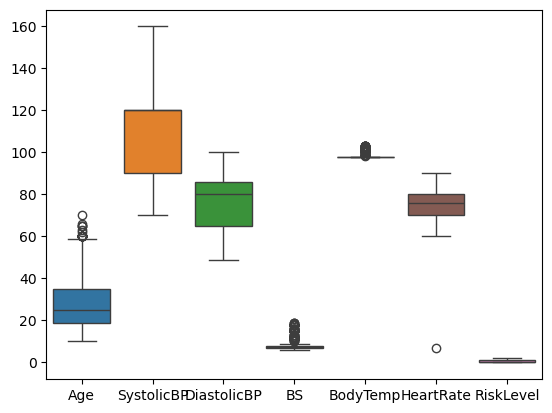

In [45]:
sns.boxplot(data=data)
plt.show()

Como vemos sólo hay outliers en la edad y en los niveles de la glucosa. Pese a esto no vamos a eliminar
los outliers ya que nos interesan para que nuestro algoritmo a que edades o niveles de glucosa haybriesgo.

## Exploratory Data Analysis

### Análisis Univariante y Bivariante

<ol>
    <li>Age Vs. Risk Level</li>
    <li>Blood Glucose Level Vs. Risk Level</li>
    <li>Blood Pressure Vs. Risk Level </li>
</ol>


**Age Vs Risk Level**

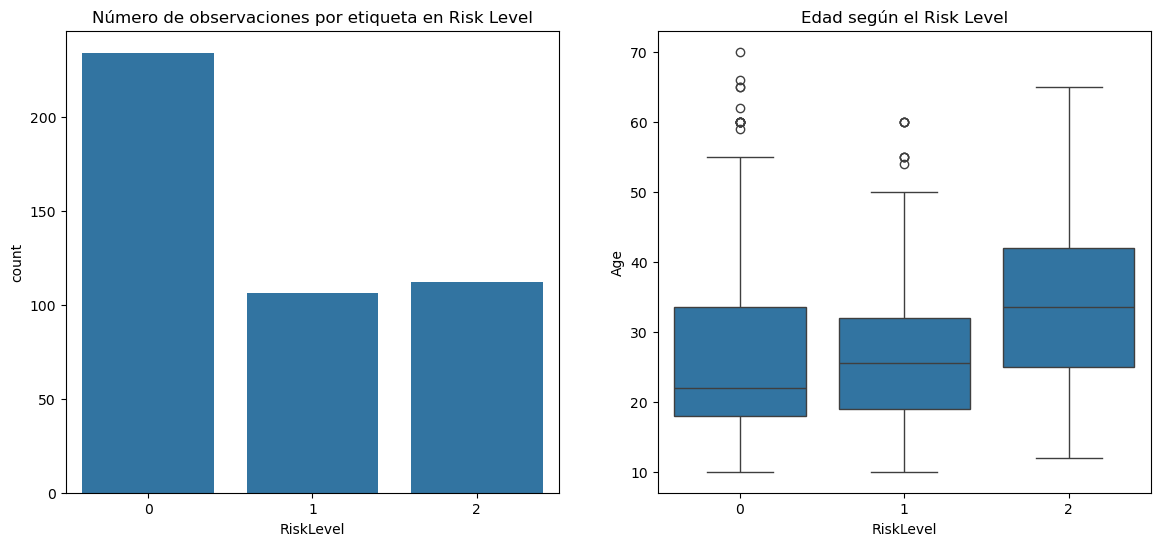

In [52]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.countplot(ax=axes[0], x=data.RiskLevel)
axes[0].set_title("Número de observaciones por etiqueta en Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.Age)
axes[1].set_title("Edad según el Risk Level");
plt.show()

Como podemos ver, hay muchas mujeres diagnosticadas de bajo riesgo. En la realidad lo normal es que
un embarazo salga bien o no presente complicaciones que lo ponga en peligro. 
Si miramos el gráfico de la derecha, podemos observar que la mayoría de los embarazos de bajo y moderado riesgo, 
se encuentran en edades más tempranas. En cambio, la media de edad de las mujeres que presentan mayor riesgo es aproximadamente
35 años. De ello podemos esperar que sí hay una relación entre Edad y Nivel de Riesgo. 

**Glucose Level Vs. Risk Level**

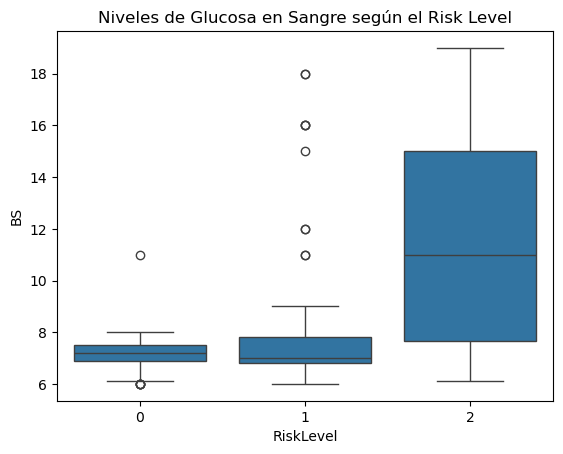

In [56]:
sns.boxplot(x=data.RiskLevel, y=data.BS).set_title("Niveles de Glucosa en Sangre según el Risk Level")
plt.show()

Como se esperaba, según aumentan los niveles de glucosa, aumenta el nivel de riesgo. 
Podemos considerar la glucosa en sangre como un factor predictivo importante para evaluar el 
nivel de riesgo. 

**Blood Pressure Vs. Risk Level**

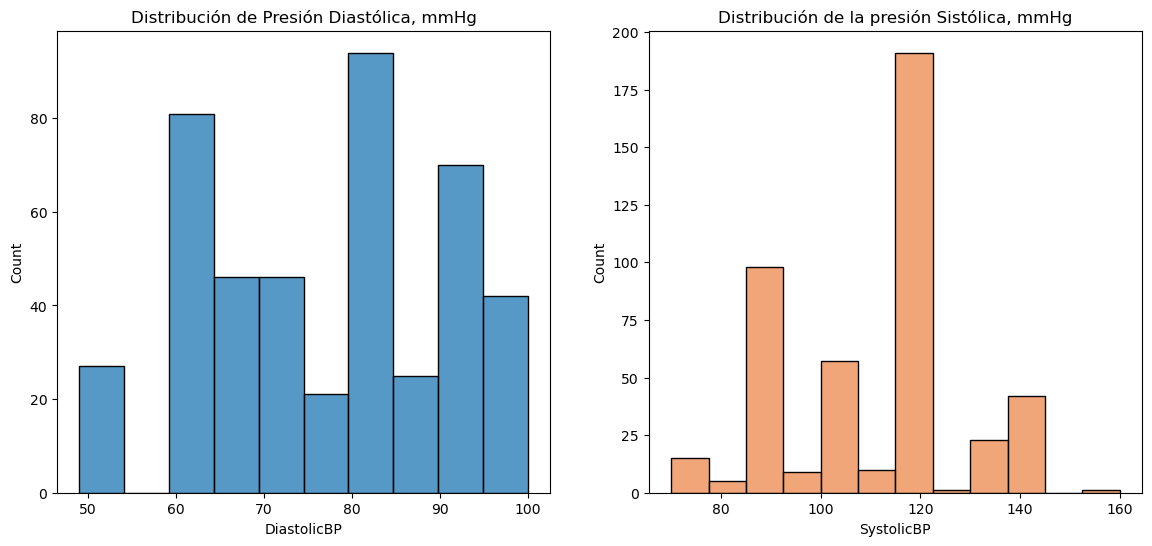

In [60]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=data.DiastolicBP)
axes[0].set_title("Distribución de Presión Diastólica, mmHg")

sns.histplot(ax=axes[1], x=data.SystolicBP, color="#ed894e")
axes[1].set_title("Distribución de la presión Sistólica, mmHg")
plt.show()

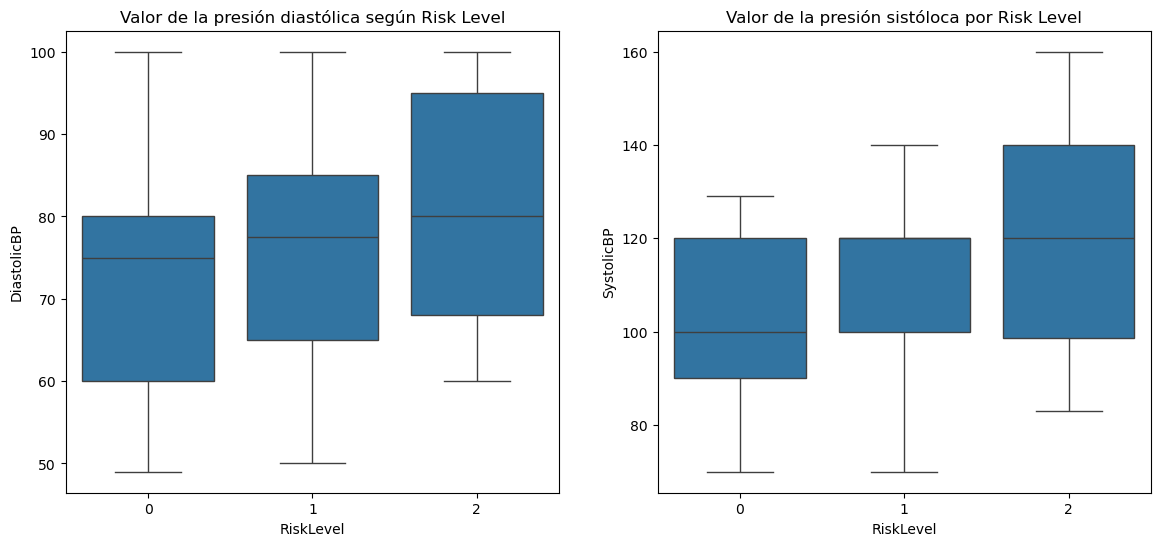

In [62]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.boxplot(ax=axes[0], x=data.RiskLevel, y=data.DiastolicBP)
axes[0].set_title("Valor de la presión diastólica según Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.SystolicBP)
axes[1].set_title("Valor de la presión sistóloca por Risk Level")
plt.show()

La relación entre presión arterial y la presión de riesgo, podemos ver que los valores de la presión arterial tienden a incre,entarse a medida que el nivel de riesgo sube. 
Este aumento puede ser un síntoma de hipertensión o preeclampsia, que son factores comunes durante el embarazo. 
Estros patrones sugieren que la presión sistólica y la diastólica son significantes de monitorizar y puedden servir como
un factor predictivo. 

Vemos a ver cómo se distribuye la presión sistólica y diastólica según la edad.

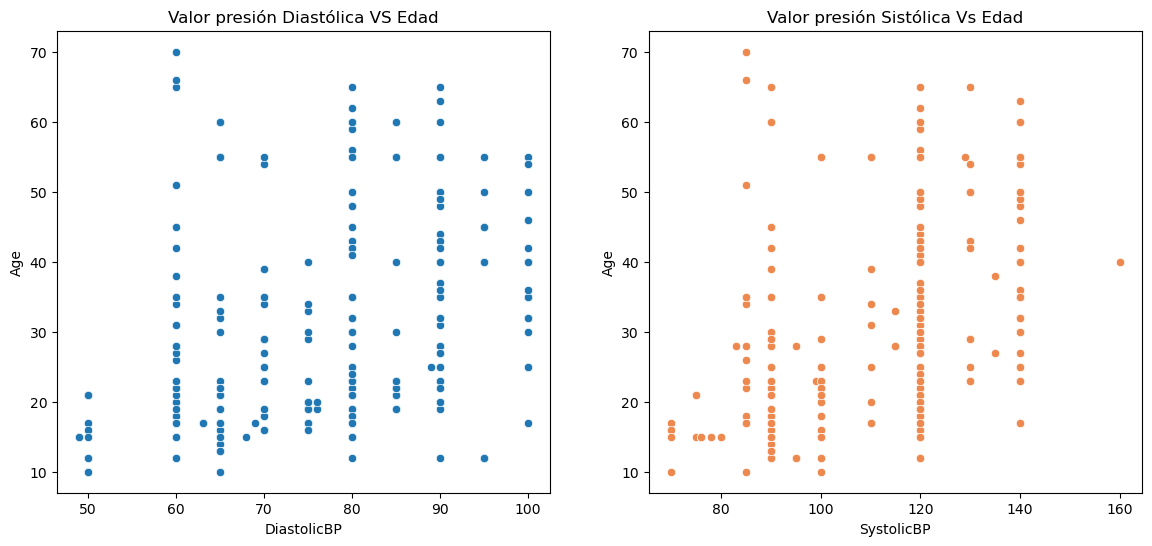

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.scatterplot(x=data.DiastolicBP, y=data.Age, ax = axes[0])
axes[0].set_title("Valor presión Diastólica VS Edad")

sns.scatterplot(ax=axes[1], x=data.SystolicBP, y = data.Age, color = "#ed894e")
axes[1].set_title("Valor presión Sistólica Vs Edad")
plt.show()

No se  observa ninguna relación entre la edad y la distribución de los valores de la presión diastólica, 
la mayoría de los puntos se encuentran entre los 60 (esta es algo baja, el rango normal es 70) y 90 mmmHg, dentro de un rango  normal. 
Igual ocurre con la gráfica de la presión sistólica según la edad, está en el rango de 90-140 mmHg. A partir de 140 mmHg seconsidere hipertensión; con lo cual la muestra es
normotensa, con una proporción en el rango de prehipertensión (presión sistólica 120-140 mmHg y presión diastólica 80-90 mmHg)


**Body Temperature Vs. Risk Level**

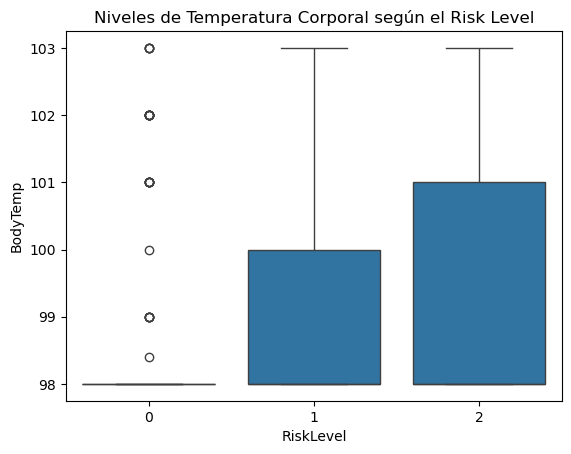

In [70]:
sns.boxplot(x=data.RiskLevel, y=data.BodyTemp).set_title("Niveles de Temperatura Corporal según el Risk Level")
plt.show()

Podemos observar que hay un aumento del nivel de temparatura según aumenta el riesgo, lo que 
sugiere una posible relación entre ambas variables. 

**HeartRate Vs. Risk Level**

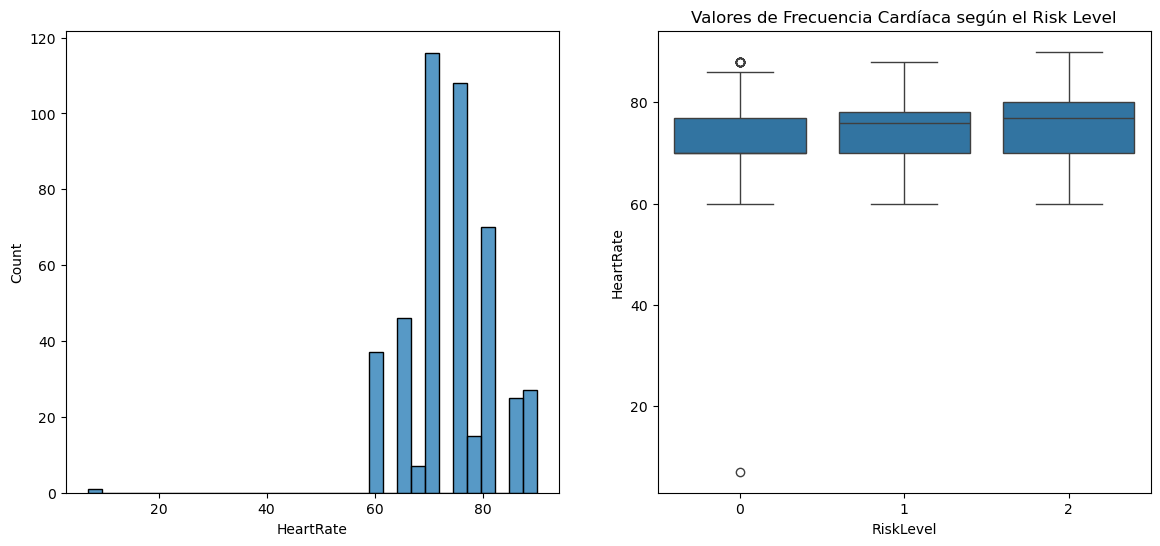

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.histplot(ax=axes[0], x=data.HeartRate)
sns.boxplot(x=data.RiskLevel, y=data.HeartRate).set_title("Valores de Frecuencia Cardíaca según el Risk Level")
plt.show()

<ol>Distribución general de la frecuencia:
    <li>La mayoría de los valores están concentrados entre 60-80 lpm.</li>
    <li>Muy  pocos valores se encuentran por debajo de 60 lpm y por encima de 80 lpm.</li>
    <li>Hay un valor menor a 20 lpm, que será un outlier a eliminar.</li>
    <li>En general la muestra tiene valores normales de frecuencia cardiaca.</li>
</ol>
<ol>Frecuencia cardíaca según nivel de riesgo:
    <li>No parece  haber ninguna diferencia significativa en la frecuencia cardíaca promedio entre los niveles de riesgo.</li>
</ol>
Esto sugiere que la variable HeartRate  no podría ser usada como valor discriminate por só sola para detectar riegos.

### CONCLUSIONES ANÁLISIS  MUESTRA

<ol>
    <li>Los embarazos de bajo riesgo son los más comunes, ocurriendo en más de la mitad de los casos.</li>
    <li>Las mujeres jóvenes tienden a tener embarazos de bajo o medio riesgo. Mientras que las mujeres mayores 
    de 35, entre medio y alto riesgo.</li>
    <li>Si una mujer embarazada tiene un nivel de azúcar en sangre superior a 8 mmol/L, el embarazo se considera de riesgo.</li>
    <li>La presión diastólica representa una distribución más alta (60-100 mmHg).</li>
</ol>

## VALORACIÓN SI SE NORMALIZA LA MUESTRA

Como en el notebook mencionado arriba menciona, la asimetría es la distorsión de la distribución de los datos, para la mayoría de los modelos de Machine learning necesitan que los datos estén normalizados. 

Vamos a usar pairplot, es parte de la ibrería Seaborn y permite explorar relaciones entre múltiples variables en un conjunto de datos. En la diagonal principal muestra gráficos de densidad de cada variable, fuera de la diagonal principal muestra relaciones bivariantes. 

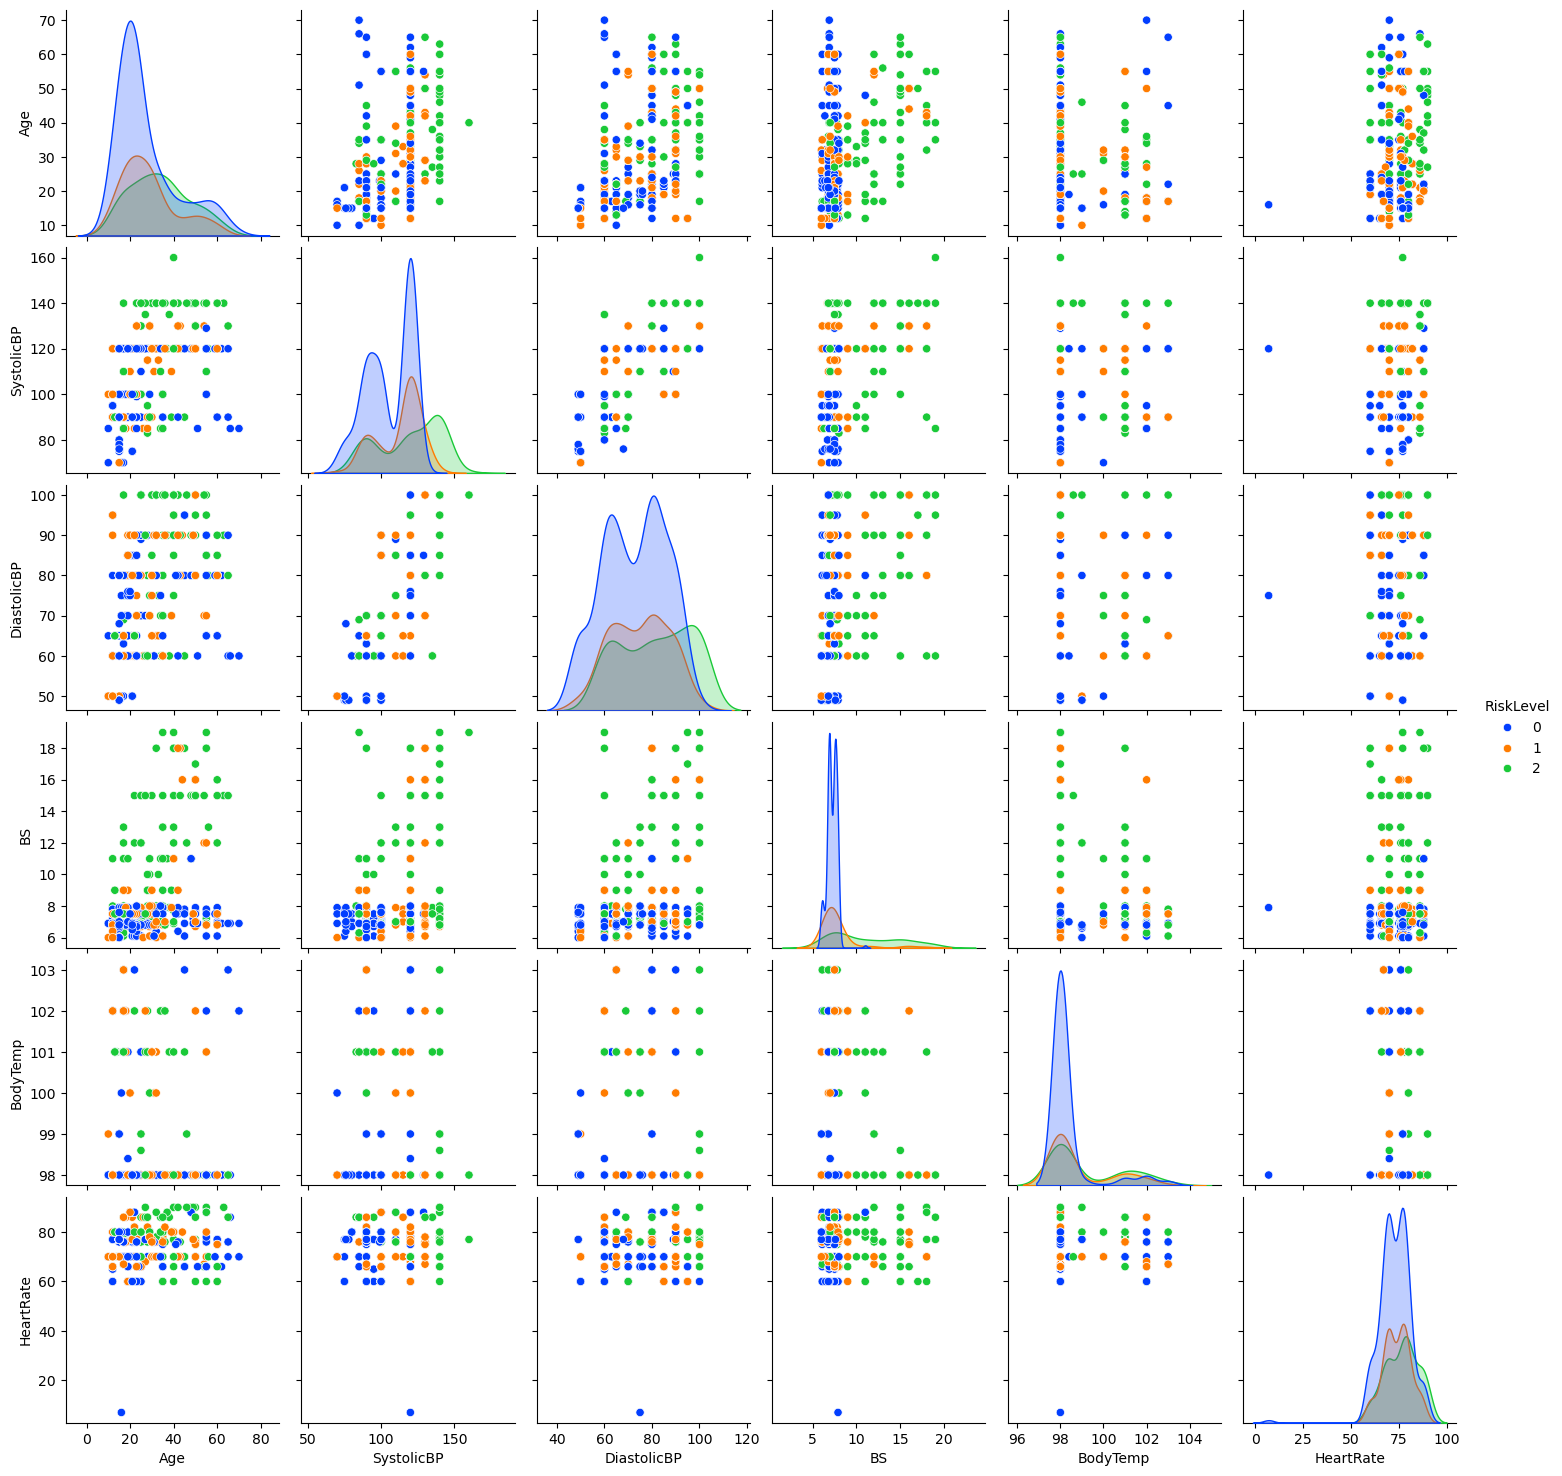

In [77]:
sns.pairplot(data, hue="RiskLevel", diag_kind="kde", palette="bright")
plt.show()

<ol>
    <li>Edad y nivel de riesgo:
    Las mujeres jóvenes tienen mayor proporción de embarazos de bajo riesgo, y las mayores de 35 se relacionan con embarazos de alto riesgo.</li>
    <li>Presión arterial y glucosa:
    Presiones altas (Psistólica > 120 mmHg, Pdiástolica > 80 mmHg) y niveles elevados de glucosa (> 8 mol/L) están relacionados con embarazos de alto riesgo).</li>
    <li>Temperatura y frecuencia cardíaca:
    las mujeres con riesgoalto tienen, general, temperaturas corporales más altas y  frecuencias cardíacas ligeramente elevadas.</li>
<li>Las variables edad, presión arterial, glucosa, temperatura presentan difrenecias claras según el nivel de riesgo, siendo en RisLevel 2 el que concentra las anomalías más marcadas.</li>

In [81]:
data.to_csv('Maternal-risk-analized.csv', index=False)
#df_transformed.to_csv('Maternal-risk-processed.csv', index=False)

Como vemos también hemos conseguido que se concentre alrededor del valor de un pico con apenas colas. 

### Separación de características y objetivo

La variable X tendra las característricas numéricas. 

La variable Y tendrá las etiquetas de la columna RiskLevel.

In [87]:
x = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']
# x = df_transformed.drop('RiskLevel', axis=1)
# y = df_transformed['RiskLevel']

## Entrenamiento del modelo

In [89]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101, stratify=y)

El modelo no parece estar overfitted para k = 19. Inicialmente, con poco datos, el modelo tiene problemas de generalizción,  por eso hay mucha diferencia inicial entre ambas curvas considerable, y el validation score empieza con un puntaje bastante bajo. 

A medida que se aumentanlos datos, las curvas convergen y muestran una tendencia positiva de forma pararlela, lo que sugiere que el modelo mejora tanto en entrenamiento como e validación con más datos. 

### Random Forest Classifier

Se basa en los modelos de árboles de decisión- 

Construye árboles de decisión independientes cada uno entrenado con un subconjunto del dataset, 
los subconjuntos se crean seleccionado de forma aleatoria muestras del dataset. y cada nodo del árbol tiene un subconjunto de caraxterísticas
seleccionadas aleatoriamente. 

De forma que para clasificar una muestra nuueva, cada árbol hace una predicción, el Random Forest combina las predicciones 
mediante voto mayoritario. 

Configuración de nuestro algoritmo:
<ol>
    <li>n_estimators: nº de árboles en el bosque, probamos con 100, 300, 500.</li>
    <li>criterion:el creiterio  que usamos para medir la calidad de divisiones de los árboles es índice de gini y
    entropía de información</li>
    <li>Profundidad mázima de los árboles: 15, 30, 50.</li>
    <li>min_samples_leaf: nº mínimo de muestras requeridas por hoja: 3, 5, 7.</li>
</ol>

Estos son los datos que probaremos a priori, sin embargo, como hemos hecho antes, 
vamos a aaplicar la estrategia de validación cruzada para buscar la mejor combinación posible. Para esta solución, 
usaremos GridSearchCV, es una tecnica para buscar hiperparámetros usando combinación cruzada para las opciones que hayamos declarado anteriormente. 

In [91]:
classifier = RandomForestClassifier(class_weight=class_weight)

#Definimos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 30, 50, 75, 100, 150],
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf': [3, 5, 7, 10,15], 
    'max_features': ['sqrt', 'log2', None, 0.6, 3], 
    'bootstrap': [True, False]
    }

#creamos objeto GridSearchCV
#Realizamos validación cruzada de 5 particiones (cv = 5)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Mejores parámetros a usar:', grid_search.best_params_)
print('Mejor precisión:', grid_search.best_score_)

#Identificación del mejor modelo
best_forest = grid_search.best_estimator_

NameError: name 'class_weight' is not defined

In [374]:
forest_pred = grid_search.predict(X_test)

In [211]:
# Crear un nuevo modelo Random Forest con los mejores parámetros
final_model = RandomForestClassifier(
    n_estimators=50,
    criterion='entropy',
    max_depth=150,
    min_samples_split=5,
    min_samples_leaf=7,
    max_features=3,
    bootstrap=True,
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
final_model.fit(X_train, y_train)

# Hacer predicciones con el modelo final
y_pred = final_model.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.97      0.83        70
           1       0.67      0.12      0.21        32
           2       0.81      0.85      0.83        34

    accuracy                           0.74       136
   macro avg       0.73      0.65      0.62       136
weighted avg       0.73      0.74      0.68       136



In [213]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(final_model, X_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.71875    0.66666667 0.63492063 0.71428571 0.73015873]
Mean CV Accuracy: 0.69


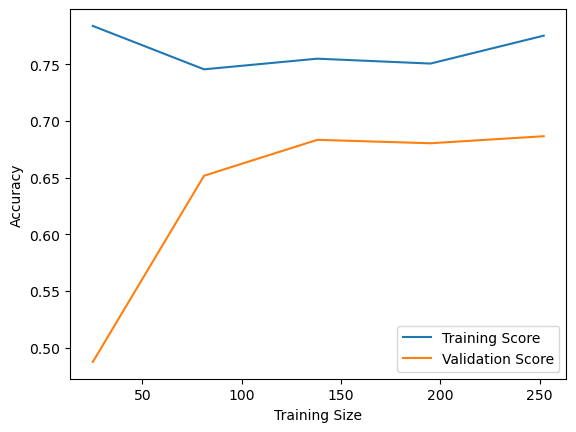

In [215]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(final_model, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

El puntaje en el entrenamiento  es consistentemente alto, alrededor de 0.77 y 0.88, lo que indica que el modelo ajusta bien los datos, aunque hay una ligera disminución 
al aumentar el conjunto de entrenamiento, pero es de esperar, ya que es más difícil ajustarcon un mayor tamaño de datos. 

En el conjunto de validación, aumenta constantemente con el tamaño del conjunto de entrenamiento yse estabiliza alrededor de 0.7. Esto sugietre que el modelo mejora su capcidad de generalización a medida que se entrena con más datos. 

Existe una pequeña brecha entre las curvas, esto indica que el modelo está funcionando razonablemente bien, con un balance entre sobreajuste y subajuste. 


In [217]:
import joblib
joblib.dump(final_model, 'maternal-risk-RF-model.pkl')
print("Modelo guardado como 'maternal-risk-RF-model.pkl'")

Modelo guardado como 'maternal-risk-RF-model.pkl'


### Gradient Boosting Classifier

In [226]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

#Modelo básico
gbc = GradientBoostingClassifier(random_state=42, 
                                n_estimators=500, learning_rate=0.01,   max_depth =5, 
                                min_samples_split=7, min_samples_leaf=5, subsample= 0.6, 
                                max_features=None)
gbc.fit(X_train, y_train)

#predicciones
y_pred = gbc.predict(X_test)

#Evaluación del Modelo
print("Accuraccy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación")
print(classification_report(y_test, y_pred))

Accuraccy: 0.7205882352941176
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.72      0.91      0.81        70
           1       0.50      0.22      0.30        32
           2       0.82      0.79      0.81        34

    accuracy                           0.72       136
   macro avg       0.68      0.64      0.64       136
weighted avg       0.69      0.72      0.69       136



**Optimización de los Hiperparámetros con GridSearchCV**
<UL>
    <li>n_estimators: número deárboles en el modelo. Más árboles mejoran el rendimiento, pwro incrementa el tiempo de entrenamiento.</li>
    <li>learning_rate: tasa de aprendizaje. Reduce la contribución de cada árbol, valores más pequeños requieren más árboles pero el modelo es más robusto.</li>
    <li>max_depth: profundidad máxima de los árboles.Limitar la profundidad reduce el sobreajuste.</li>
    <li>loss: para la clasificación, función de pérdida a optimizar. Suelen ser <code>log_loss</code> (para clasificación o <code>exponential</code>.</li>
    <li>min_samples_split: número mínimo de muestras necesarias para dividir un nodo. Controla la creación de nodos de un árbol. Valores más altos hacen que el árbol sea  más restrictivo.</li>
    <li>min_samples_leaf: número mínimo de muestras en una hoja.</li>
    <li>max_leaf_nodes: número máximo de hojas en el árbol, limita la complejidad del modelo.</li>
    <li>max_features: número máximo de características consideradas para dividir un nodo. Hay varias opciones: auto o sqrt (raíz cuadrada del númerototal de características), log2 (logaritmo base 2 del número total de características), o None (todas las características). </li>
    <li>subsample: fracción de datos usada para entrenar cada árbol, los valores menores a 1 introducen aleatoriedad y ayudan a reducir el sobreajuste.</li>
    <li>criterion: función que mide la división; opciones: friedman_mse: es el predeterminado, squared_error: error cuadrático medio, o mae: error absoluto medio (más robusto a outliers). </li>
</UL>

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500, 700], 
    'learning_rate':[0.001,0.01, 0.05, 0.1],
    'max_depth':[2,3,4,5,7], 
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf':[1,2,4,6,8], 
    'subsample':[0.5, 0.6, 0.8, 1.0], 
    'max_features':['sqrt', 'log2', None],
    'criterion': ['friedman_mse', 'squarred_error', 'mae']
}

grid_search = GridSearchCV(
    estimator=gbc, 
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

Fitting 5 folds for each of 72000 candidates, totalling 360000 fits


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

#Modelo básico
gbc = GradientBoostingClassifier(random_state=42, 
                                n_estimators=200, class_weight = 'balanced', 
                                learning_rate=0.01,   max_depth =5, 
                                min_samples_split=7, min_samples_leaf=5, subsample= 0.6, 
                                max_features=None)
gbc.fit(X_train, y_train)

#predicciones
y_pred = gbc.predict(X_test)

#Evaluación del Modelo
print("Accuraccy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación")
print(classification_report(y_test, y_pred))

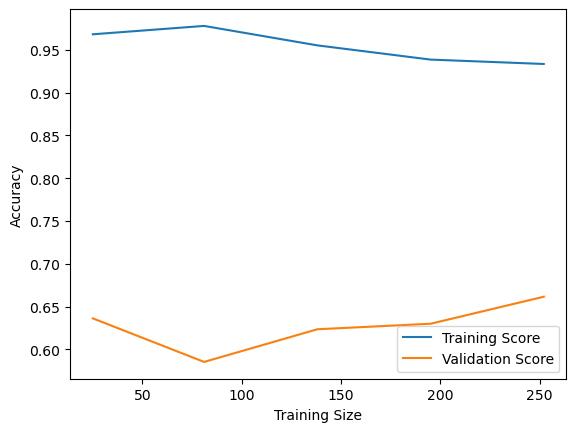

In [878]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(gbc, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# PRUEBA CON DATOS WEARABLE

Vamos a estudiar el riesgo que hay por día, semana y mes

In [955]:
wearable_data = pd.read_csv('wearable-simulation-pregnancy.csv')

entrenar al modelo con mis datos del wearable

In [957]:
wearable_data.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester
0,user_0000,32,2024-06-16 02:45:05,89.0,134.0,8.26,98.696800,100.0,2024-06-16,2024-06,2024-06-16,3,First
1,user_0000,32,2024-06-16 10:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
2,user_0000,32,2024-06-16 18:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
3,user_0000,31,2024-06-18 07:37:54,87.0,133.0,8.86,98.843603,121.0,2024-06-18,2024-06,2024-06-18,3,First
4,user_0000,31,2024-06-18 15:37:54,86.0,131.0,7.99,98.870108,102.0,2024-06-18,2024-06,2024-06-18,3,First


In [1094]:
wearable_data['week'].nunique()

25

In [1090]:
# Agrupamos los datos por user_id y day para calcular el promedio diario de los isgnos vitales

daily_data = wearable_data.groupby(['user_id', 'date']).agg({
    'DiastolicBP': 'mean',
    'SystolicBP': 'mean',
    'BS': 'mean',
    'BodyTemp': 'mean',
    'HeartRate': 'mean',
    'Age': 'first' # La edad no varía durante el embarazo
}).reset_index()
daily_data.head()


,user_id,date,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,Age
0,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32
1,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31
2,user_0000,2024-06-19,87.666667,130.333333,8.243333,98.678435,108.333333,32
3,user_0000,2024-06-20,86.666667,130.333333,8.280000,98.566905,107.666667,32
4,user_0000,2024-06-22,86.000000,131.000000,8.400000,98.706873,107.666667,32


In [1075]:
daily_data = daily_data.merge(wearable_data[['user_id', 'date', 'week', 'trimester']], 
                              on=['user_id', 'date'], 
                              how='inner')

daily_data.head()

,user_id,date,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,Age,week,trimester
0,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
1,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
2,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
3,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First
4,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First


In [963]:
model_rf = joblib.load('maternal-risk-RF-model.pkl')
print("Modelo cargado exitosamente")

Modelo cargado exitosamente


In [1077]:
# Hacemos predicciones con modelo entrenado
X_daily = daily_data[['DiastolicBP', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate', 'Age']]
daily_data['risk'] = model_rf.predict(X_daily)
daily_data.head(10)

C:\Users\virginia.anton\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,user_id,date,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,Age,week,trimester,risk
0,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First,2
1,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First,2
2,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First,2
3,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First,2
4,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First,2
5,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First,2
6,user_0000,2024-06-19,87.666667,130.333333,8.243333,98.678435,108.333333,32,3,First,2
7,user_0000,2024-06-19,87.666667,130.333333,8.243333,98.678435,108.333333,32,3,First,2
8,user_0000,2024-06-19,87.666667,130.333333,8.243333,98.678435,108.333333,32,3,First,2
9,user_0000,2024-06-20,86.666667,130.333333,8.280000,98.566905,107.666667,32,3,First,2


In [1079]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4026 entries, 0 to 4025
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      4026 non-null   object 
 1   date         4026 non-null   object 
 2   DiastolicBP  4026 non-null   float64
 3   SystolicBP   4026 non-null   float64
 4   BS           4026 non-null   float64
 5   BodyTemp     4026 non-null   float64
 6   HeartRate    4026 non-null   float64
 7   Age          4026 non-null   int64  
 8   week         4026 non-null   int64  
 9   trimester    4026 non-null   object 
 10  risk         4026 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 346.1+ KB


In [1081]:
daily_data.describe()

,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,Age,week,risk
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.0
mean,76.725230,121.036397,6.905115,98.639604,111.403005,31.543716,16.718579,2.0
std,9.808957,9.537667,1.740273,0.611636,9.906568,2.705357,10.328326,0.0
min,61.000000,101.000000,3.375000,96.033333,70.000000,19.000000,1.000000,2.0
25%,65.089844,110.089844,5.575000,98.506107,104.500000,32.000000,4.000000,2.0
50%,78.809570,122.542792,6.216667,98.567862,107.000000,32.000000,17.000000,2.0
75%,86.666667,130.666667,8.276667,98.719238,122.500000,32.000000,29.000000,2.0
max,103.194447,144.722225,13.000000,106.500000,159.000000,45.000000,32.000000,2.0


## Riesgos semanales:

In [1084]:
#resumimos los riesgos semanalmente, vamos a devolver la clase más frecuente para cada usuario esa semana.
weekly_risk = daily_data.groupby(['user_id', 'week'])['risk'].agg(lambda x: x.value_counts().idxmax()).reset_index()
weekly_risk.head(10)

,user_id,week,risk
0,user_0000,3,2
1,user_0000,4,2
2,user_0000,5,2
3,user_0000,16,2
4,user_0000,17,2
5,user_0000,18,2
6,user_0000,29,2
7,user_0000,30,2
8,user_0000,31,2
9,user_0001,1,2


In [1088]:
daily_data['week'].unique()

array([ 3,  4,  5, 16, 17, 18, 29, 30, 31,  1,  9, 10, 14, 19, 22, 23, 27,
        2,  6, 28, 32, 15, 13, 26, 24], dtype=int64)

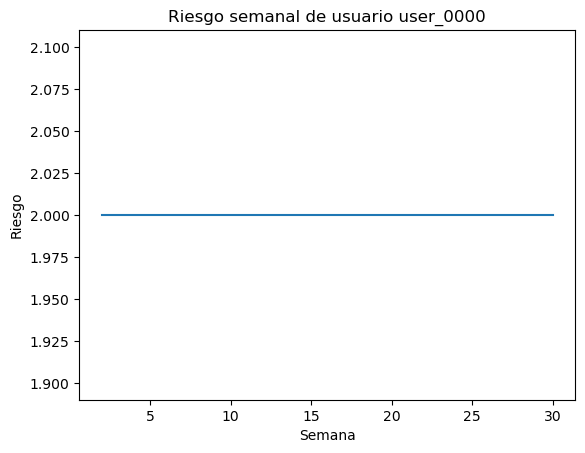

In [979]:
#Visualizamos los datos
import matplotlib.pyplot as plt

user_weekly_risk = weekly_risk[weekly_risk['user_id'] == 'user_0099']
plt.plot(user_weekly_risk['week'], user_weekly_risk['risk'])
plt.xlabel('Semana')
plt.ylabel('Riesgo')
plt.title('Riesgo semanal de usuario user_0000')
plt.show()


## Riesgo del trimestre

In [991]:
trimester_risk = daily_data.groupby(['user_id', 'trimester'])['risk'].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Renombrar columnas para claridad
trimester_risk.columns = ['user_id', 'trimester', 'trimester_risk']
trimester_risk.head(10)

,user_id,trimester,trimester_risk
0,user_0000,First,2
1,user_0000,Second,2
2,user_0000,Third,2
3,user_0001,First,2
4,user_0001,Second,2
5,user_0001,Third,2
6,user_0002,First,2
7,user_0002,Second,2
8,user_0002,Third,2
9,user_0003,First,2


In [997]:
print(daily_data['risk'].isna().sum())

0


Máximo riesgo en el trimestre

In [1031]:

daily_data['risk_numeric'] = daily_data['risk']
print(daily_data['risk_numeric'])
# Encontrar valores no reconocidos
unmapped_values = daily_data[~daily_data['risk'].isin(risk_map.keys())]['risk'].unique()
print("Valores no reconocidos:", unmapped_values)


0       2
1       2
2       2
3       2
4       2
       ..
1567    2
1568    2
1569    2
1570    2
1571    2
Name: risk_numeric, Length: 1572, dtype: int64
Valores no reconocidos: [2]


In [1033]:
trimester_risk = daily_data.groupby(['user_id', 'trimester'])['risk_numeric'].max().reset_index()

#convertimos riesgo numérico a texto otra vez
reverse_risk_map = {0: 'low risk', 1:'mid risk', 2:'high risk'}
trimester_risk['trimester_risk'] = trimester_risk['risk_numeric'].map(reverse_risk_map)

# #eliminamos columna auxiliar
# trimester_risk.drop('risk_numeric', axis=1, inplace=True)
trimester_risk.head()

,user_id,trimester,risk_numeric,trimester_risk
0,user_0000,First,2,high risk
1,user_0000,Second,2,high risk
2,user_0000,Third,2,high risk
3,user_0001,First,2,high risk
4,user_0001,Second,2,high risk


Combinamos los datos de riesgos semanalas y trimestales en un sólo dataset: 

Vamos a crear un dataset más detallado, vamos a añadir datos de qué semanas corresponden a qué trimestre. 


In [1035]:
combined_weeklyTrimestral_risk = weekly_risk.merge(
    trimester_risk, 
    on='user_id', 
    how='left'
)
C.head()
    

,user_id,week,risk,trimester_x,trimester_y,risk_numeric,trimester_risk
0,user_0000,3,2,First,First,2,high risk
1,user_0000,3,2,First,Second,2,high risk
2,user_0000,3,2,First,Third,2,high risk
3,user_0000,4,2,First,First,2,high risk
4,user_0000,4,2,First,Second,2,high risk


In [1037]:
combined_weeklyTrimestral_risk.drop('trimester_y', axis=1)

,user_id,week,risk,trimester_x,risk_numeric,trimester_risk
0,user_0000,3,2,First,2,high risk
1,user_0000,3,2,First,2,high risk
2,user_0000,3,2,First,2,high risk
3,user_0000,4,2,First,2,high risk
4,user_0000,4,2,First,2,high risk
...,...,...,...,...,...,...
2308,user_0099,28,2,Third,2,high risk
2309,user_0099,28,2,Third,2,high risk
2310,user_0099,30,2,Third,2,high risk
2311,user_0099,30,2,Third,2,high risk


In [1044]:
combined_weeklyTrimestral_risk.to_csv('combined_risk_summary.csv', index=False)

Resultado Final:

Dataset con
<ul>
    <li>user_id: identificador único del usuario. </li>
    <li>week: semana específica del riesgo semanal.</li>
    <li>weekly_risk: riesgo semanal calculado.</li>
    <li>trimester:Trimestre correspondiente a cada semana.</li>
    <li>trimester_risk: riesgo total del trimestre.</li>
</ul>

## VISUALIZACIÓN DE LAS ESTADÍSTICAS RIESGO DE LOS DATOS DEL WEARABLE

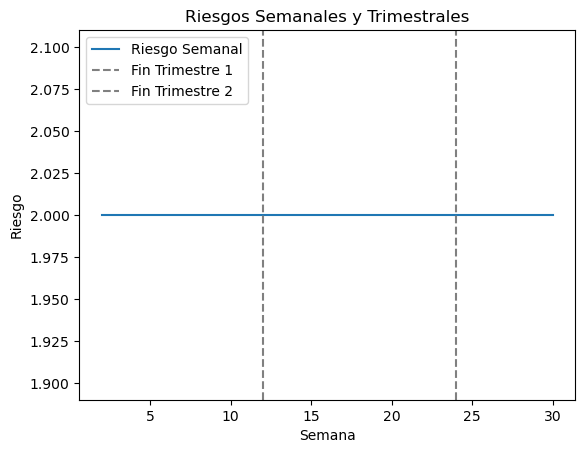

In [1054]:
import matplotlib.pyplot as plt

#visualización riesgos semanales y trimestrales por usuarios
user_data = combined_weeklyTrimestral_risk[combined_weeklyTrimestral_risk['user_id'] =='user_0099']

#Gráfica riesgo semanal
plt.plot(user_data['week'], user_data['risk'], label='Riesgo Semanal')
plt.axvline(x=12, color='gray', linestyle='--', label = 'Fin Trimestre 1')
plt.axvline(x=24, color='gray', linestyle='--', label = 'Fin Trimestre 2')
plt.xlabel('Semana')
plt.ylabel('Riesgo')
plt.title('Riesgos Semanales y Trimestrales')
plt.legend()
plt.show()

## PREDICCIÓN PARA DATOS DE LA CONSULTA